# Customer Data Preparation for Machine Learning

This notebook connects to a PostgreSQL database, loads customer churn data, performs data cleaning, handles categorical columns, and prepares the data for ML models.

## 1. Setup & Connection

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

In [2]:
# Load environment variables from .env file
load_dotenv('../.env')

DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = os.getenv('DB_HOST', 'localhost')
DB_PORT = os.getenv('DB_PORT', '5432')
DB_NAME = os.getenv('DB_NAME', 'telco_churn')

if not DB_USER or not DB_PASSWORD:
    raise ValueError('DB_USER and DB_PASSWORD must be set in .env file')

connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)
print(f"✓ Connected to {DB_NAME} at {DB_HOST}:{DB_PORT}")

✓ Connected to postgres at localhost:5432


## 2. Load Data

In [3]:
query = "SELECT * FROM public.customers;"
df = pd.read_sql(query, engine)
print(f"✓ Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")

✓ Data loaded: 7043 rows, 21 columns


## 3. Exploratory Data Analysis (EDA)

In [4]:
print("First 5 rows:")
df.head()

First 5 rows:


,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,False,True,False,1,False,No phone service,DSL,No,...,No,No,No,No,Month-to-month,True,Electronic check,29.85,29.85,False
1,5575-GNVDE,Male,False,False,False,34,True,No,DSL,Yes,...,Yes,No,No,No,One year,False,Mailed check,56.95,1889.50,False
2,3668-QPYBK,Male,False,False,False,2,True,No,DSL,Yes,...,No,No,No,No,Month-to-month,True,Mailed check,53.85,108.15,True
3,7795-CFOCW,Male,False,False,False,45,False,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,False,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,Female,False,False,False,2,True,No,Fiber optic,No,...,No,No,No,No,Month-to-month,True,Electronic check,70.70,151.65,True


In [5]:
print("DataFrame Info:")
df.info()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   bool   
 3   partner            7043 non-null   bool   
 4   dependents         7043 non-null   bool   
 5   tenure             7043 non-null   int64  
 6   phone_service      7043 non-null   bool   
 7   multiple_lines     7043 non-null   object 
 8   internet_service   7043 non-null   object 
 9   online_security    7043 non-null   object 
 10  online_backup      7043 non-null   object 
 11  device_protection  7043 non-null   object 
 12  tech_support       7043 non-null   object 
 13  streaming_tv       7043 non-null   object 
 14  streaming_movies   7043 non-null   object 
 15  contract           7043 non-null   object 
 16  paperles

In [6]:
print("Data Types:")
df.dtypes

Data Types:


customer_id           object
gender                object
senior_citizen          bool
partner                 bool
dependents              bool
tenure                 int64
phone_service           bool
multiple_lines        object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
contract              object
paperless_billing       bool
payment_method        object
monthly_charges      float64
total_charges        float64
churn                   bool
dtype: object

### 3.1 Visualizations

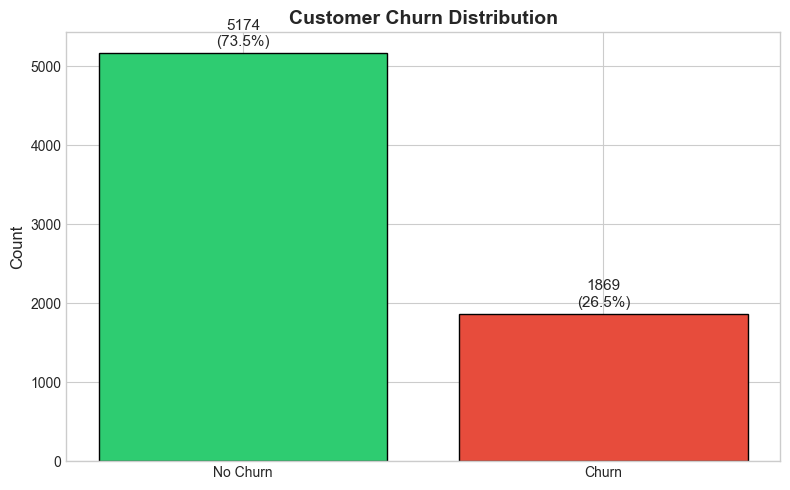

In [7]:
# Churn Distribution
fig, ax = plt.subplots(figsize=(8, 5))
churn_counts = df['churn'].value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = ax.bar(['No Churn', 'Churn'], churn_counts.values, color=colors, edgecolor='black')
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Customer Churn Distribution', fontsize=14, fontweight='bold')

for bar, count in zip(bars, churn_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{count}\n({count/len(df)*100:.1f}%)', 
            ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

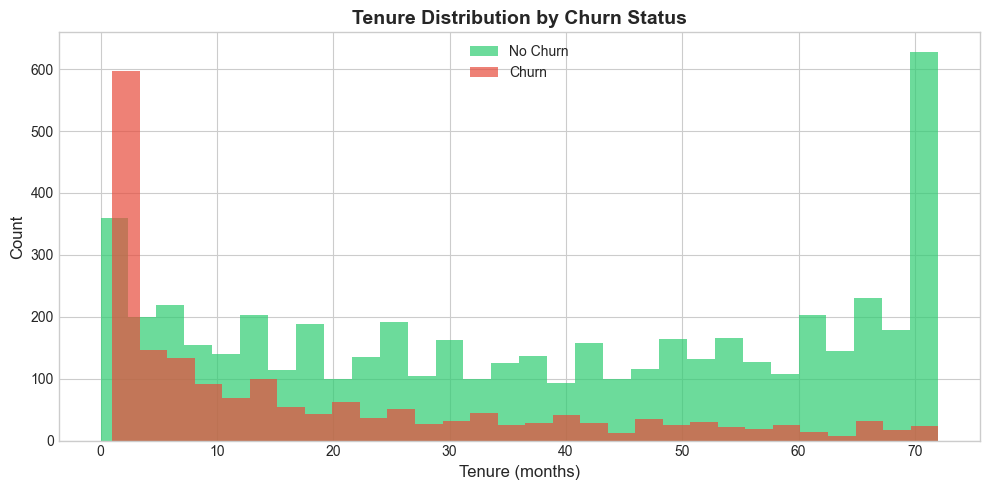

In [8]:
# Tenure Distribution by Churn
fig, ax = plt.subplots(figsize=(10, 5))
df[df['churn'] == False]['tenure'].hist(alpha=0.7, bins=30, label='No Churn', color='#2ecc71', ax=ax)
df[df['churn'] == True]['tenure'].hist(alpha=0.7, bins=30, label='Churn', color='#e74c3c', ax=ax)
ax.set_xlabel('Tenure (months)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Tenure Distribution by Churn Status', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

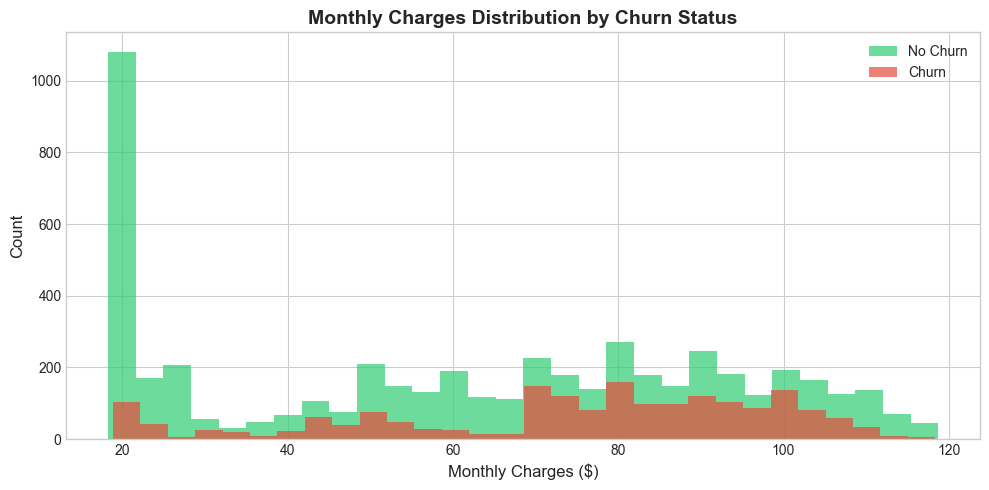

In [9]:
# Monthly Charges Distribution by Churn
fig, ax = plt.subplots(figsize=(10, 5))
df[df['churn'] == False]['monthly_charges'].hist(alpha=0.7, bins=30, label='No Churn', color='#2ecc71', ax=ax)
df[df['churn'] == True]['monthly_charges'].hist(alpha=0.7, bins=30, label='Churn', color='#e74c3c', ax=ax)
ax.set_xlabel('Monthly Charges ($)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Monthly Charges Distribution by Churn Status', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

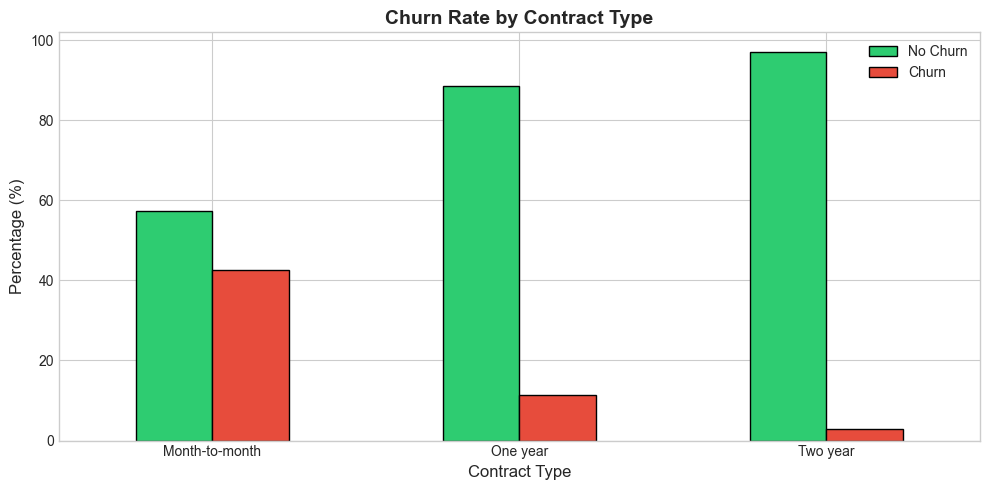

In [10]:
# Contract Type vs Churn
fig, ax = plt.subplots(figsize=(10, 5))
contract_churn = pd.crosstab(df['contract'], df['churn'], normalize='index') * 100
contract_churn.plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'], edgecolor='black')
ax.set_xlabel('Contract Type', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Churn Rate by Contract Type', fontsize=14, fontweight='bold')
ax.legend(['No Churn', 'Churn'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

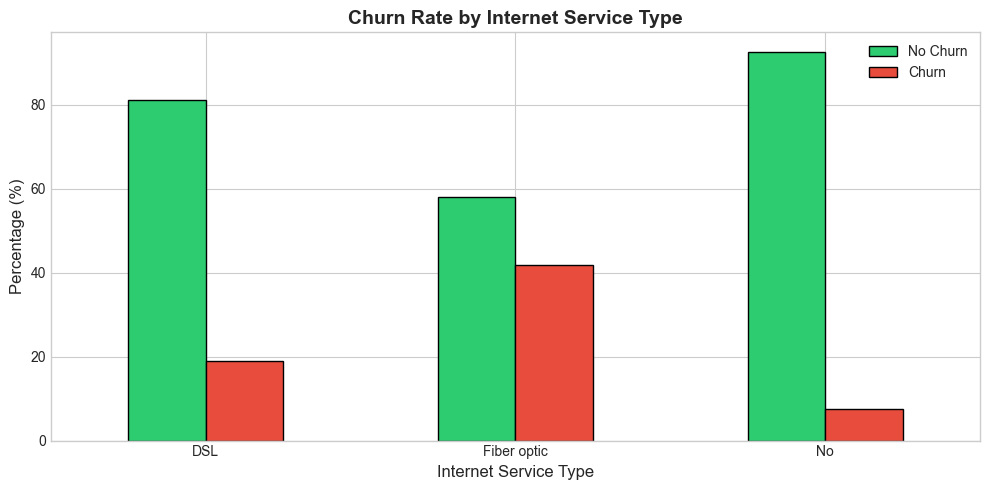

In [11]:
# Internet Service vs Churn
fig, ax = plt.subplots(figsize=(10, 5))
internet_churn = pd.crosstab(df['internet_service'], df['churn'], normalize='index') * 100
internet_churn.plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'], edgecolor='black')
ax.set_xlabel('Internet Service Type', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Churn Rate by Internet Service Type', fontsize=14, fontweight='bold')
ax.legend(['No Churn', 'Churn'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

## 4. Data Cleaning

### 4.1 Handle Missing Values

In [12]:
# Check null values
null_counts = df.isnull().sum()
null_summary = null_counts[null_counts > 0]
print(f"Columns with null values:\n{null_summary}")

Columns with null values:
total_charges    11
dtype: int64


In [13]:
# Fill nulls in total_charges with median
if df['total_charges'].isnull().any():
    median_val = df['total_charges'].median()
    df['total_charges'].fillna(median_val, inplace=True)
    print(f"✓ Filled total_charges nulls with median: {median_val}")

print(f"Remaining nulls: {df.isnull().sum().sum()}")

✓ Filled total_charges nulls with median: 1397.475
Remaining nulls: 0


### 4.2 Remove Duplicates

In [14]:
print(f"Duplicates: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
df.drop_duplicates(subset=['customer_id'], keep='first', inplace=True)
print(f"Shape after removing duplicates: {df.shape}")

Duplicates: 0
Shape after removing duplicates: (7043, 21)


### 4.3 Inspect Categorical Columns

In [15]:
# Check unique values in object columns
print("Unique values in categorical columns:")
print("=" * 60)

object_columns = df.select_dtypes(include='object').columns

for col in object_columns:
    unique_vals = df[col].unique()
    print(f"\n{col} ({len(unique_vals)} unique):")
    print(f"  {unique_vals}")

Unique values in categorical columns:

customer_id (7043 unique):
  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

gender (2 unique):
  ['Female' 'Male']

multiple_lines (3 unique):
  ['No phone service' 'No' 'Yes']

internet_service (3 unique):
  ['DSL' 'Fiber optic' 'No']

online_security (3 unique):
  ['No' 'Yes' 'No internet service']

online_backup (3 unique):
  ['Yes' 'No' 'No internet service']

device_protection (3 unique):
  ['No' 'Yes' 'No internet service']

tech_support (3 unique):
  ['No' 'Yes' 'No internet service']

streaming_tv (3 unique):
  ['No' 'Yes' 'No internet service']

streaming_movies (3 unique):
  ['No' 'Yes' 'No internet service']

contract (3 unique):
  ['Month-to-month' 'One year' 'Two year']

payment_method (4 unique):
  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


### 4.4 Convert Boolean Columns to 0/1

In [16]:
# Check unique values in boolean columns first
boolean_columns = ['senior_citizen', 'partner', 'dependents', 'phone_service',
                   'paperless_billing', 'churn']

print("Unique values in boolean columns:")
for col in boolean_columns:
    if col in df.columns:
        print(f"{col}: {df[col].unique()}")

Unique values in boolean columns:
senior_citizen: [False  True]
partner: [ True False]
dependents: [False  True]
phone_service: [False  True]
paperless_billing: [ True False]
churn: [False  True]


In [17]:
# Convert boolean columns to 0/1
for col in boolean_columns:
    if col in df.columns:
        df[col] = df[col].astype(int)

print("✓ Boolean columns converted to 0/1")

✓ Boolean columns converted to 0/1


### 4.5 Convert Service Columns (Yes/No/No service) to 0/1

In [18]:
# These columns have Yes/No/No phone service or No internet service
# Since "No phone/internet service" is redundant (already in phone_service/internet_service), treat as 0

service_columns = ['multiple_lines', 'online_security', 'online_backup', 
                   'device_protection', 'tech_support', 'streaming_tv', 
                   'streaming_movies']

for col in service_columns:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: 1 if x == 'Yes' else 0)

print("✓ Service columns converted to 0/1")

✓ Service columns converted to 0/1


## 5. Handle Categorical Columns for ML

Remaining object columns that need encoding:
- `customer_id` → Drop (identifier, not a feature)
- `gender` → One-Hot Encoding (Male, Female) - keep both
- `internet_service` → One-Hot Encoding (DSL, Fiber optic) - exclude 'No'
- `contract` → One-Hot Encoding (Month-to-month, One year, Two year) - keep all
- `payment_method` → One-Hot Encoding (all 4 types) - keep all

In [19]:
# Check remaining object columns after previous conversions
remaining_object_cols = df.select_dtypes(include='object').columns.tolist()
print(f"Remaining object columns: {remaining_object_cols}")

for col in remaining_object_cols:
    print(f"\n{col}: {df[col].unique()}")

Remaining object columns: ['customer_id', 'gender', 'internet_service', 'contract', 'payment_method']

customer_id: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

gender: ['Female' 'Male']

internet_service: ['DSL' 'Fiber optic' 'No']

contract: ['Month-to-month' 'One year' 'Two year']

payment_method: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


### 5.1 Drop customer_id (Not a Feature)

In [20]:
# Save customer_id separately if needed later, then drop
customer_ids = df['customer_id'].copy()
df.drop('customer_id', axis=1, inplace=True)
print("✓ Dropped customer_id column")

✓ Dropped customer_id column


### 5.2 One-Hot Encode Categorical Columns

In [21]:
print("Before encoding:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Before encoding:
Shape: (7043, 20)
Columns: ['gender', 'senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'churn']


In [22]:
# Custom One-Hot Encoding
# Rule: Only exclude 'No' values (meaning absence/nothing), keep all actual values

print("Applying One-Hot Encoding...")
print("=" * 60)

# Gender: Keep BOTH Male and Female (both are real values)
df['gender_Male'] = (df['gender'] == 'Male').astype(int)
df['gender_Female'] = (df['gender'] == 'Female').astype(int)
df.drop('gender', axis=1, inplace=True)
print("✓ gender → gender_Male, gender_Female")

# Internet Service: Exclude 'No' (it means no internet service)
# Keep DSL and Fiber optic only
df['internet_service_DSL'] = (df['internet_service'] == 'DSL').astype(int)
df['internet_service_Fiber_optic'] = (df['internet_service'] == 'Fiber optic').astype(int)
df.drop('internet_service', axis=1, inplace=True)
print("✓ internet_service → internet_service_DSL, internet_service_Fiber_optic (excluded 'No')")

# Contract: Keep ALL values (none of them mean 'No' or absence)
df['contract_Month_to_month'] = (df['contract'] == 'Month-to-month').astype(int)
df['contract_One_year'] = (df['contract'] == 'One year').astype(int)
df['contract_Two_year'] = (df['contract'] == 'Two year').astype(int)
df.drop('contract', axis=1, inplace=True)
print("✓ contract → contract_Month_to_month, contract_One_year, contract_Two_year")

# Payment Method: Keep ALL values (none of them mean 'No' or absence)
df['payment_method_Electronic_check'] = (df['payment_method'] == 'Electronic check').astype(int)
df['payment_method_Mailed_check'] = (df['payment_method'] == 'Mailed check').astype(int)
df['payment_method_Bank_transfer'] = (df['payment_method'] == 'Bank transfer (automatic)').astype(int)
df['payment_method_Credit_card'] = (df['payment_method'] == 'Credit card (automatic)').astype(int)
df.drop('payment_method', axis=1, inplace=True)
print("✓ payment_method → payment_method_Electronic_check, payment_method_Mailed_check, payment_method_Bank_transfer, payment_method_Credit_card")

print("\n" + "=" * 60)
print("One-Hot Encoding completed!")

Applying One-Hot Encoding...
✓ gender → gender_Male, gender_Female
✓ internet_service → internet_service_DSL, internet_service_Fiber_optic (excluded 'No')
✓ contract → contract_Month_to_month, contract_One_year, contract_Two_year
✓ payment_method → payment_method_Electronic_check, payment_method_Mailed_check, payment_method_Bank_transfer, payment_method_Credit_card

One-Hot Encoding completed!


In [23]:
print("\nAfter One-Hot Encoding:")
print(f"Shape: {df.shape}")
print(f"\nNew columns: {df.columns.tolist()}")


After One-Hot Encoding:
Shape: (7043, 27)

New columns: ['senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'monthly_charges', 'total_charges', 'churn', 'gender_Male', 'gender_Female', 'internet_service_DSL', 'internet_service_Fiber_optic', 'contract_Month_to_month', 'contract_One_year', 'contract_Two_year', 'payment_method_Electronic_check', 'payment_method_Mailed_check', 'payment_method_Bank_transfer', 'payment_method_Credit_card']


## 6. Final Data Validation

In [24]:
print("=" * 60)
print("DATA PREPARATION SUMMARY")
print("=" * 60)
print(f"Total records: {len(df)}")
print(f"Total features: {len(df.columns)}")
print(f"Remaining nulls: {df.isnull().sum().sum()}")
print(f"Remaining object columns: {df.select_dtypes(include='object').columns.tolist()}")
print("=" * 60)

DATA PREPARATION SUMMARY
Total records: 7043
Total features: 27
Remaining nulls: 0
Remaining object columns: []


In [25]:
print("Final DataFrame Info:")
df.info()

Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   senior_citizen                   7043 non-null   int64  
 1   partner                          7043 non-null   int64  
 2   dependents                       7043 non-null   int64  
 3   tenure                           7043 non-null   int64  
 4   phone_service                    7043 non-null   int64  
 5   multiple_lines                   7043 non-null   int64  
 6   online_security                  7043 non-null   int64  
 7   online_backup                    7043 non-null   int64  
 8   device_protection                7043 non-null   int64  
 9   tech_support                     7043 non-null   int64  
 10  streaming_tv                     7043 non-null   int64  
 11  streaming_movies                 7043 non-null   int64  
 12

In [26]:
print("Final Data Types:")
df.dtypes

Final Data Types:


senior_citizen                       int64
partner                              int64
dependents                           int64
tenure                               int64
phone_service                        int64
multiple_lines                       int64
online_security                      int64
online_backup                        int64
device_protection                    int64
tech_support                         int64
streaming_tv                         int64
streaming_movies                     int64
paperless_billing                    int64
monthly_charges                    float64
total_charges                      float64
churn                                int64
gender_Male                          int64
gender_Female                        int64
internet_service_DSL                 int64
internet_service_Fiber_optic         int64
contract_Month_to_month              int64
contract_One_year                    int64
contract_Two_year                    int64
payment_met

In [27]:
print("Sample of prepared data:")
df.head()

Sample of prepared data:


,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,gender_Female,internet_service_DSL,internet_service_Fiber_optic,contract_Month_to_month,contract_One_year,contract_Two_year,payment_method_Electronic_check,payment_method_Mailed_check,payment_method_Bank_transfer,payment_method_Credit_card
0,0,1,0,1,0,0,0,1,0,0,...,1,1,0,1,0,0,1,0,0,0
1,0,0,0,34,1,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,0
2,0,0,0,2,1,0,1,1,0,0,...,0,1,0,1,0,0,0,1,0,0
3,0,0,0,45,0,0,1,0,1,1,...,0,1,0,0,1,0,0,0,1,0
4,0,0,0,2,1,0,0,0,0,0,...,1,0,1,1,0,0,1,0,0,0


### 6.1 Correlation Heatmap

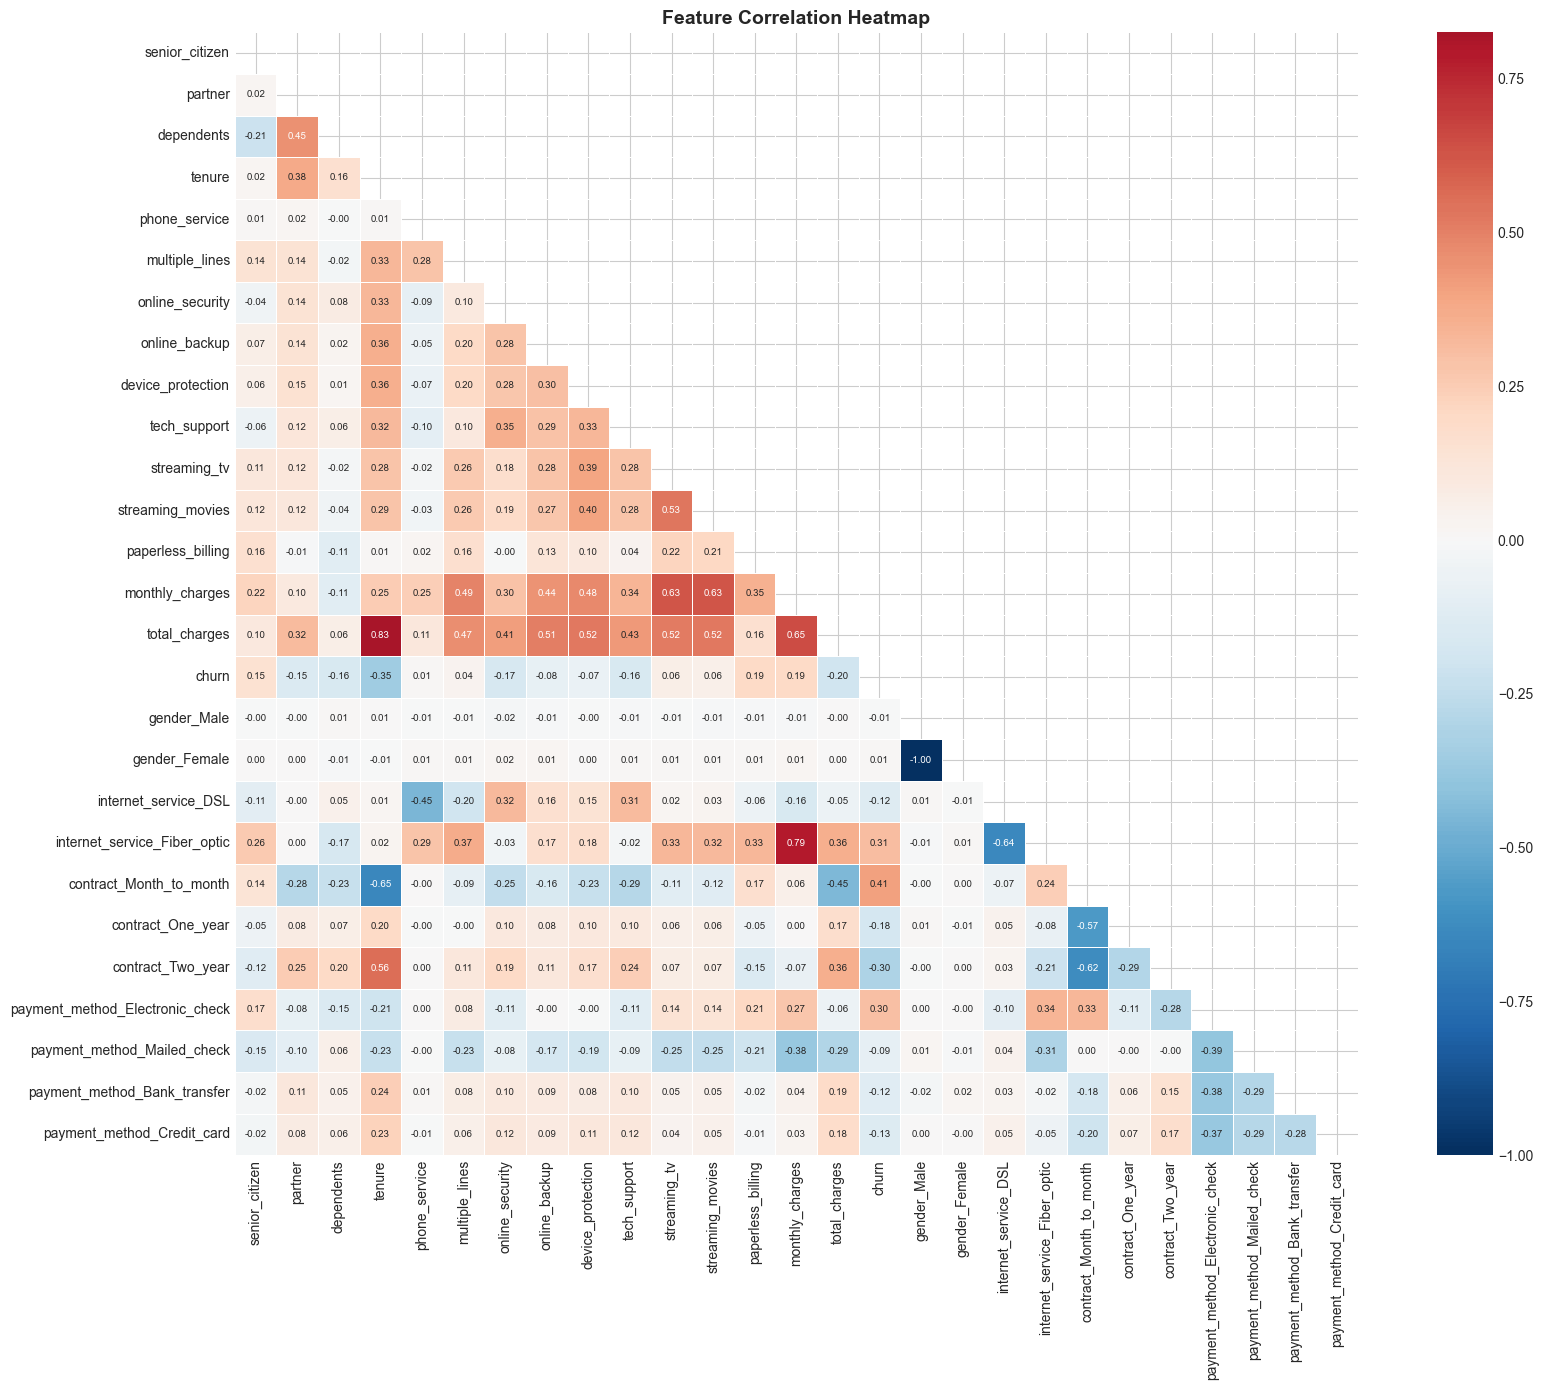

In [31]:
# Correlation heatmap for numerical features
fig, ax = plt.subplots(figsize=(18, 14))
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5, ax=ax, annot_kws={'size': 7})
ax.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Export Preprocessed Data

In [28]:
# Save prepared data
output_path = '../data/preprocessed_customers.csv'
df.to_csv(output_path, index=False)
print(f"✓ Preprocessed data saved to: {output_path}")
print(f"  - Records: {len(df)}")
print(f"  - Features: {len(df.columns)}")

✓ Preprocessed data saved to: ../data/preprocessed_customers.csv
  - Records: 7043
  - Features: 27


In [29]:
# Verify saved file
df_verify = pd.read_csv(output_path)
print(f"✓ Verified: {len(df_verify)} rows loaded")
df_verify.head(3)

✓ Verified: 7043 rows loaded


,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,gender_Female,internet_service_DSL,internet_service_Fiber_optic,contract_Month_to_month,contract_One_year,contract_Two_year,payment_method_Electronic_check,payment_method_Mailed_check,payment_method_Bank_transfer,payment_method_Credit_card
0,0,1,0,1,0,0,0,1,0,0,...,1,1,0,1,0,0,1,0,0,0
1,0,0,0,34,1,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,0
2,0,0,0,2,1,0,1,1,0,0,...,0,1,0,1,0,0,0,1,0,0


## 8. Close Connection

In [30]:
engine.dispose()
print("✓ Database connection closed")

✓ Database connection closed


---
## Summary

### Data Cleaning:
1. Filled 11 null values in `total_charges` with median
2. Removed duplicates
3. Converted boolean columns (True/False) → 0/1
4. Converted service columns (Yes/No/No service) → 0/1

### Categorical Encoding (One-Hot):
1. **Dropped**: `customer_id` (identifier, not a feature)
2. `gender` → `gender_Male`, `gender_Female` (keep all)
3. `internet_service` → `internet_service_DSL`, `internet_service_Fiber_optic` (excluded 'No' only)
4. `contract` → `contract_Month_to_month`, `contract_One_year`, `contract_Two_year` (keep all)
5. `payment_method` → 4 columns for each payment type (keep all)

### Output:
- Preprocessed dataset saved to `preprocessed_customers.csv`
- All features are numeric (int64 or float64)
- Target variable: `churn` (0/1)
- Ready for ML model training!